# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from ddpg_agent import Agent
from model import Actor, Critic

from collections import deque
import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import datetime

In [6]:
def reset_env(env, brain_name, train_mode, verbose = False):
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name]
    
    if verbose:
        # number of agents in the environment
        print('Number of agents:', num_agents)
        
        # size of each action
        print('Size of each action:', action_size)

        # number of actions
        action_size = brain.vector_action_space_size
        print('Number of actions:', action_size)

        # examine the state space 
        states = env_info.vector_observations
        state_size = states[0].shape[1]
        print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
        print('The state for the first agent looks like:', states[0])

    return env_info

In [7]:
def get_data_from_env_info(env_info, verbose = False):
    states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    
    return states, rewards, dones

In [8]:
# https://makersportal.com/blog/2018/8/14/real-time-graphing-in-python

# use ggplot style for more sophisticated visuals
plt.style.use('ggplot')

def live_plotter(x_vec,y1_data,line1,identifier='',pause_time=0.1):
    if line1==[]:
        # this is the call to matplotlib that allows dynamic plotting
        plt.ion()
        fig = plt.figure(figsize=(13,6))
        ax = fig.add_subplot(111)
        # create a variable for the line so we can later update it
        line1, = ax.plot(x_vec,y1_data,'-o',alpha=0.8)        
        #update plot label/title
        plt.ylabel('Y Label')
        plt.title('Title: {}'.format(identifier))
        plt.show()
    
    # after the figure, axis, and line are created, we only need to update the y-data
    line1.set_ydata(y1_data)
    # adjust limits if new data goes beyond bounds
    if np.min(y1_data)<=line1.axes.get_ylim()[0] or np.max(y1_data)>=line1.axes.get_ylim()[1]:
        plt.ylim([np.min(y1_data)-np.std(y1_data),np.max(y1_data)+np.std(y1_data)])
    # this pauses the data so the figure/axis can catch up - the amount of pause can be altered above
    plt.pause(pause_time)
    
    # return line so we can update it again in the next iteration
    return line1

In [9]:
def ddpg(agents, env, brain_name, n_episodes=300, max_t=1000, print_every=100,
         filename_actor='checkpoint_actor.pth', filename_critic='checkpoint_critic.pth'):
    
    # start real time plotting
    #plt.ion()
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #line1, = ax.plot([], [],'-o',alpha=0.8)
    #plt.show()
    #plt.axis([0, 300, 0, 35])
    #fig, ax = plt.subplots()
    #line = []
    
    num_agents = len(agents)
    
    average_scores = []
    average_scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        
        env_info = reset_env(env, brain_name, train_mode=True)
        states, _0, _1 = get_data_from_env_info(env_info)
        
        for agent in agents:
            agent.reset()
        
        for t in range(max_t):
            actions = [agents[i].act(states[i]) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name]
            
            next_states, rewards, dones = get_data_from_env_info(env_info)
            
            for a in range(num_agents):
                agents[a].step(states[a], actions[a], rewards[a], next_states[a], dones[a])
            
            Agent.step_timestap(t)
            
            states = next_states
            scores += rewards
            
            if (np.any(dones)):
                break
        
        episode_mean_scores = np.mean(scores)
        average_scores_deque.append(episode_mean_scores)
        average_scores.append(episode_mean_scores)
        
        # plotting intermediate results 
        #plt.scatter(i_episode, episode_mean_scores)
        #plt.show()
        #ax1.plot(range(1, i_episode+1), average_scores)
        #plt.show()
        #line = live_plotter(range(1, i_episode+1), average_scores, line)
        
        # prints
        print('\rEpisode {0}\tScore: {1:.2f} \tAverage Score (last 100): {2:.2f}'.format(i_episode, episode_mean_scores, np.mean(average_scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {0}\tScore: {1:.2f} \tAverage Score (last 100): {2:.2f}'.format(i_episode, episode_mean_scores, np.mean(average_scores_deque)))
        if np.mean(average_scores_deque)>=30.0 and len(average_scores_deque)==100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(average_scores_deque)))
            torch.save(Agent.actor_local.state_dict(), filename_actor)
            torch.save(Agent.critic_local.state_dict(), filename_critic)
            break
        
    return average_scores

In [10]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [11]:
def watch_agents(agents, brain_name, filename_actor='checkpoint_actor.pth', filename_critic='checkpoint_critic.pth',
                n_episodes = 5, max_t = 200, random_seed = 0):
    # load the weights from files
    Agent.actor_local.load_state_dict(torch.load(filename_actor))
    Agent.critic_local.load_state_dict(torch.load(filename_critic))

    episode_mean_scores, average_scores = [], []
    
    for i_episode in range(n_episodes):
        scores = np.zeros(num_agents)
        
        env_info = reset_env(env, brain_name, train_mode=True)
        states, rewards, dones = get_data_from_env_info(env_info)
        
        for t in range(max_t):
            actions = [agents[i].act(states[i]) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name]
            states, rewards, dones = get_data_from_env_info(env_info)
            scores += rewards
            if np.any(dones):
                break
        
        episode_mean_scores = np.mean(scores)
        average_scores.append(episode_mean_scores)
        print("Episode {0} average of total rewards: {1}".format(i_episode+1, episode_mean_scores))
    
    print("Average score of agents: {0}".format(np.mean(average_scores)))

In [12]:
#Seed
random_seed = 987;

#Creating agents with shared networks
agents = [Agent(state_size, action_size, random_seed) for _ in range(num_agents)]

In [13]:
#Evaluating algorithm and getting average scores between agents in each episode
start = time.time()
average_scores = ddpg(agents, env, brain_name, print_every=1)
end = time.time()

elapsedTime = str(datetime.timedelta(milliseconds=round(end - start)))
print("\nElapsed DDPG execution time: {0}".format(elapsedTime))

C:\workspace\ud-deep-reinforcement-learning\p2_continuous-control\ddpg_agent.py:147: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(cls.critic_local.parameters(), 1)


Episode 1	Score: 0.64 	Average Score (last 100): 0.64
Episode 2	Score: 1.09 	Average Score (last 100): 0.87
Episode 3	Score: 1.86 	Average Score (last 100): 1.20
Episode 4	Score: 2.27 	Average Score (last 100): 1.47
Episode 5	Score: 2.84 	Average Score (last 100): 1.74
Episode 6	Score: 3.08 	Average Score (last 100): 1.96
Episode 7	Score: 3.72 	Average Score (last 100): 2.21
Episode 8	Score: 4.99 	Average Score (last 100): 2.56
Episode 9	Score: 4.23 	Average Score (last 100): 2.75
Episode 10	Score: 5.28 	Average Score (last 100): 3.00
Episode 11	Score: 6.28 	Average Score (last 100): 3.30
Episode 12	Score: 6.84 	Average Score (last 100): 3.59
Episode 13	Score: 7.74 	Average Score (last 100): 3.91
Episode 14	Score: 8.77 	Average Score (last 100): 4.26
Episode 15	Score: 9.18 	Average Score (last 100): 4.59
Episode 16	Score: 9.07 	Average Score (last 100): 4.87
Episode 17	Score: 9.53 	Average Score (last 100): 5.14
Episode 18	Score: 10.02 	Average Score (last 100): 5.41
Episode 19	Score: 

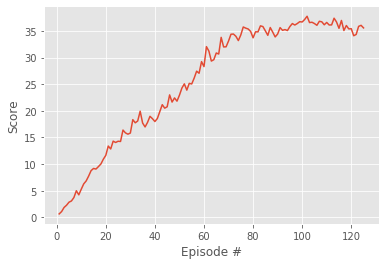

In [14]:
plot_scores(average_scores)

In [15]:
watch_agents(agents, brain_name, random_seed=random_seed)

Episode 1 average of total rewards: 6.620999852009118
Episode 2 average of total rewards: 6.446999855898321
Episode 3 average of total rewards: 6.671999850869179
Episode 4 average of total rewards: 6.15749986236915
Episode 5 average of total rewards: 6.522499854210764
Average score of agents: 6.483999855071306


In [16]:
env.close()